Copy files to project

In [84]:
import os
from pathlib import Path
from shutil import copyfile
import re 
import platform
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import re
import pickle



In [85]:
# load everything 

metadata_calibre = pickle.load(open( "pickled_metadata/calibre_metadata.p", "rb" ))

metadata_goodreads = pickle.load(open( "pickled_metadata/metadata_goodreads.p", "rb" ))




In [86]:
metadata_goodreads.query('title=="James Dean"')

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0.1, bookID, title, authors, average_rating, isbn, isbn13, language_code,   num_pages, ratings_count, text_reviews_count, publication_date, publisher, year_first_published, author, clean_title, num_words_title, len_clean_title, first_author, word_freq_on_english, aliases]
Index: []

[0 rows x 22 columns]

In [87]:

#G = pickle.load(open( "pickled_graphs/small_graph.p", "rb" ))
G = pickle.load(open( "pickled_graphs/complete_graph_by_script.p", "rb" ))

# Plot Graph Data and export json to use on web page!

In [88]:
pg = nx.pagerank(G)

sorted(pg.items(), key=lambda item: item[1],reverse=True)[:10]


[('The Prince', 0.01081877301303925),
 ('Hamlet', 0.01061937268317937),
 ('The Divine Comedy', 0.007740738803800382),
 ('The Art of War', 0.006072207782683749),
 ('Romeo and Juliet', 0.0051880591489493295),
 ('Phaedrus', 0.004890520471208026),
 ('Star Wars', 0.00483189566226892),
 ('Poetics', 0.003865239838704173),
 ('The Deep', 0.0037173564227710025),
 ('Alice in Wonderland', 0.0037039373900383415)]

In [89]:
G.remove_nodes_from(list(nx.isolates(G)))

## Export Full graph data

In [90]:

import math

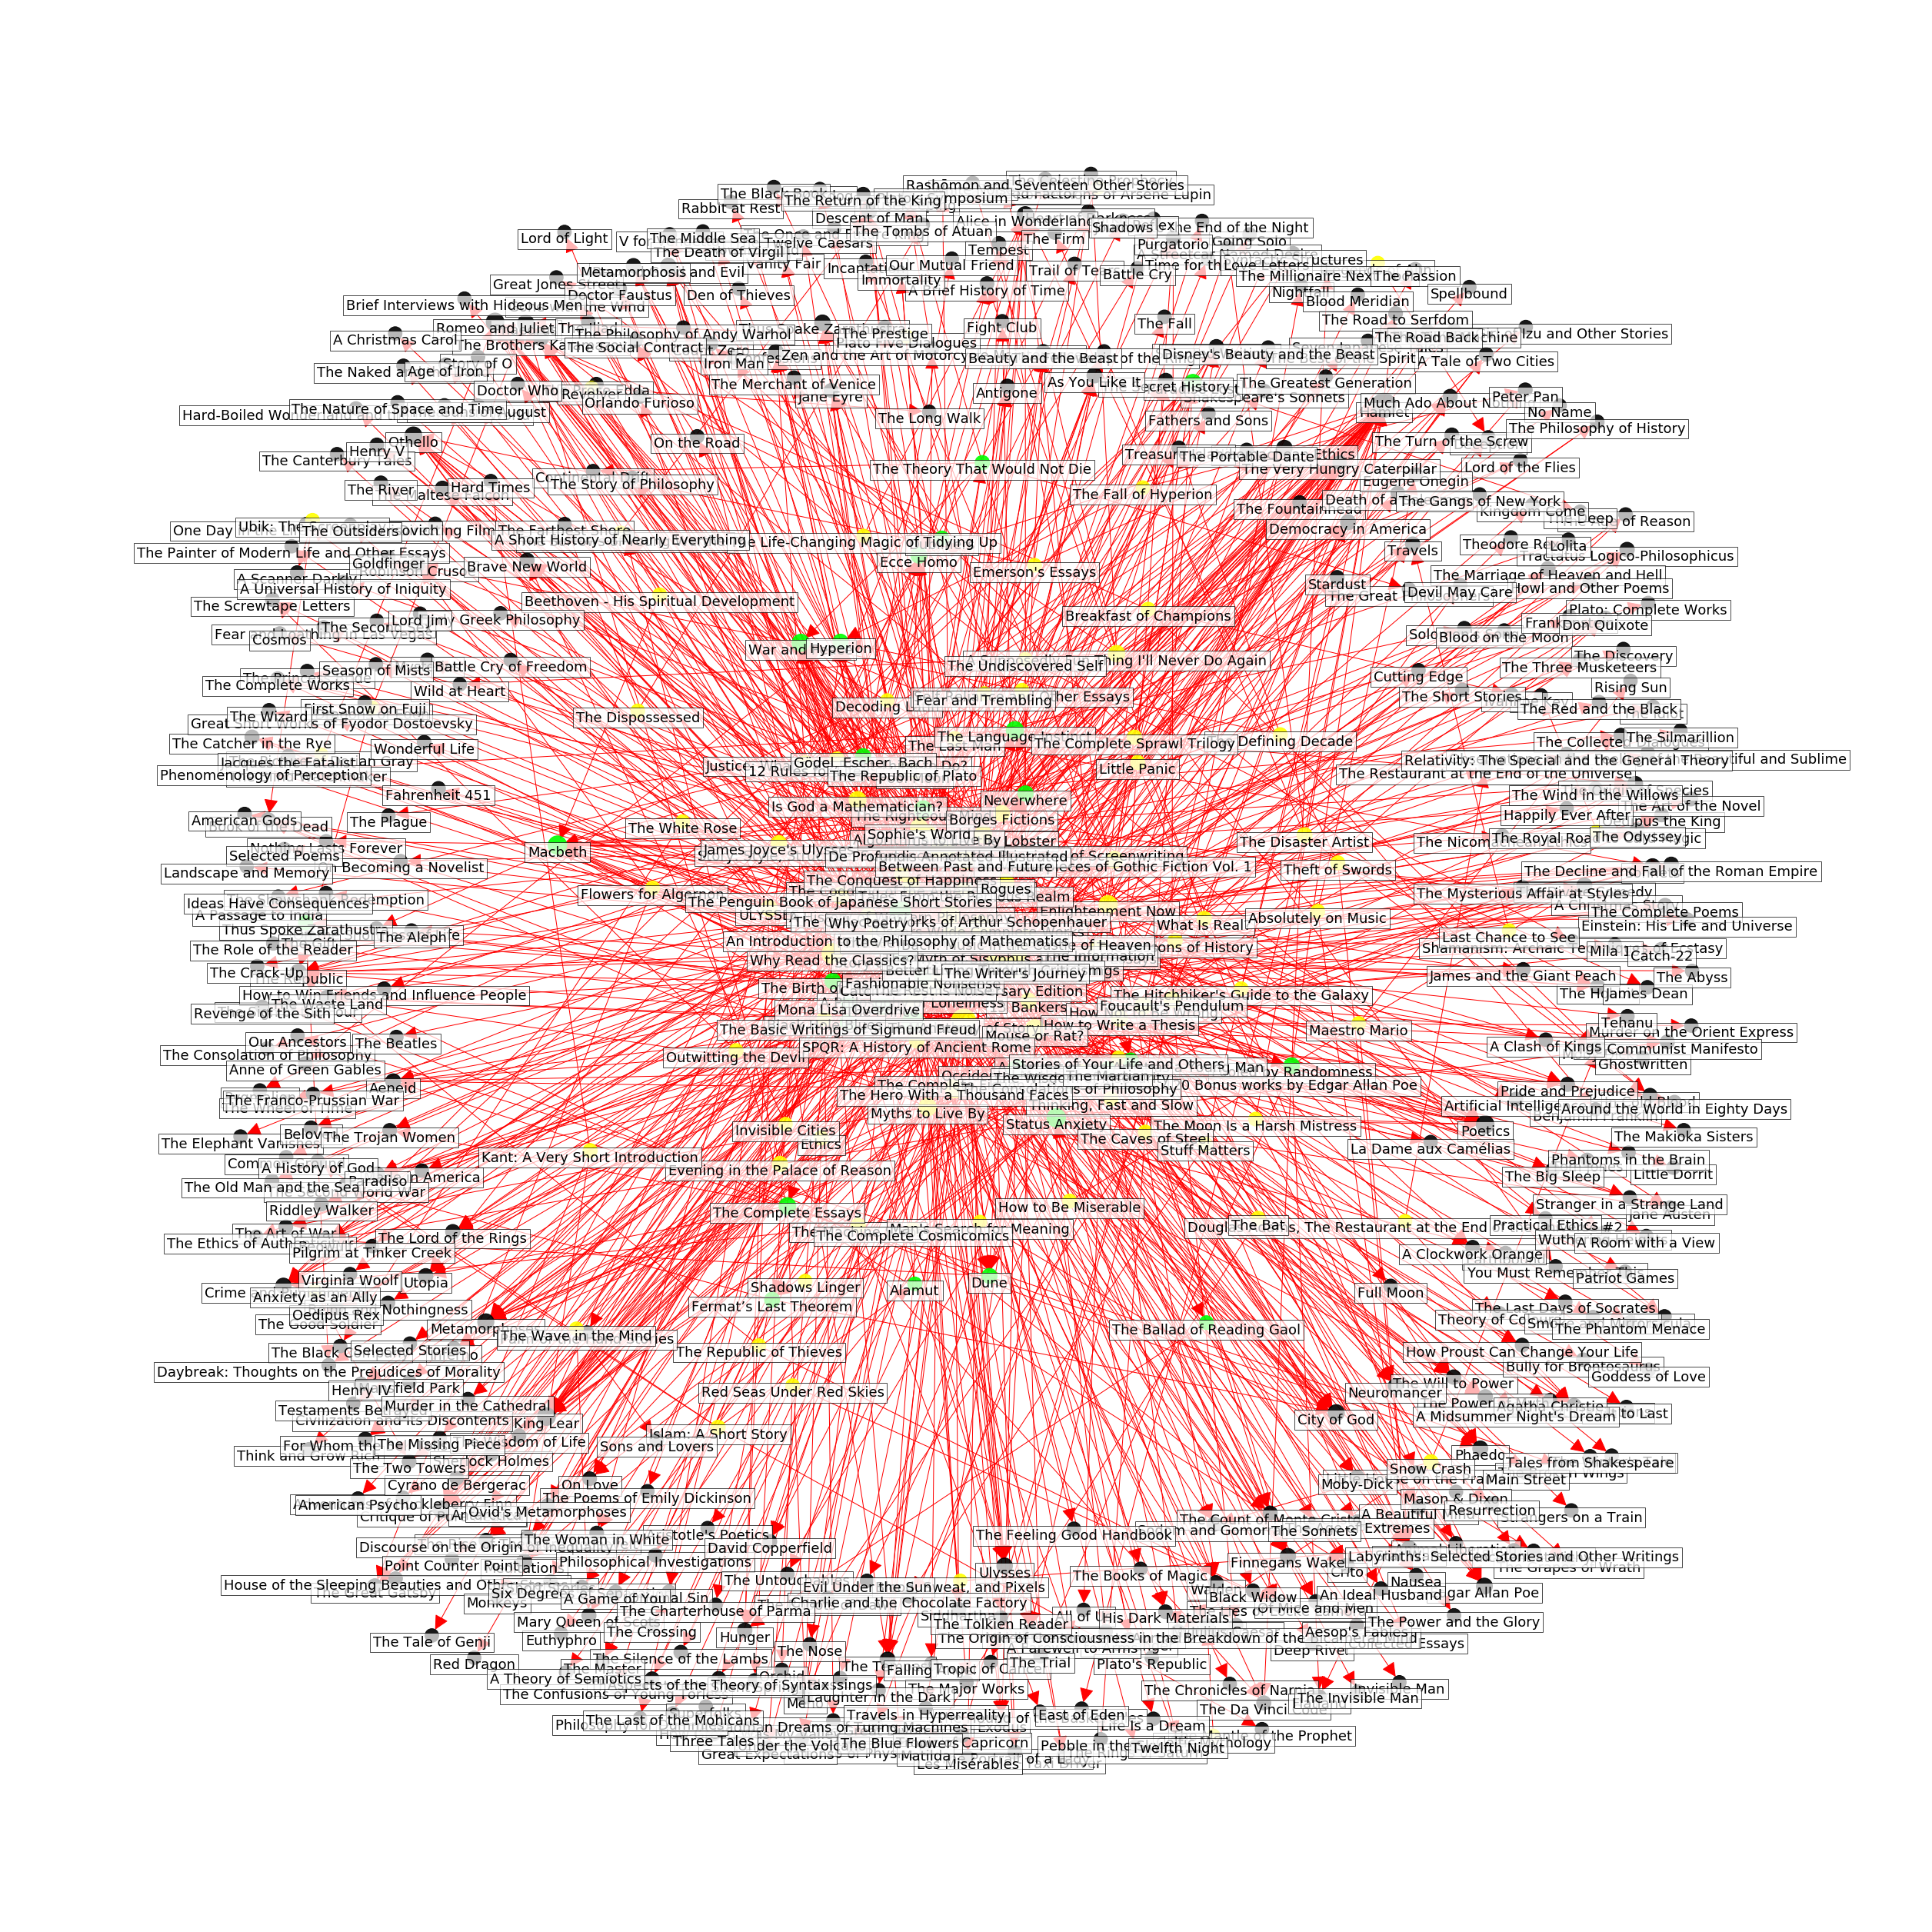

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(35, 35),)


len_pred = [len(list(G.predecessors(v))) for v in G]

reds = [math.ceil(float(i)/sum(len_pred)) for i in len_pred]

len_sucs = [len(list(G.successors(v))) for v in G]

greens = [math.ceil(float(i)/sum(len_sucs)) for i in len_sucs]


nodecolor = [ (1-r,g,0,1) for r,g in zip(reds,greens)]




nodesize = [(len(list(G.predecessors(v))) +len(list(G.successors(v))))  * 15 + 300 for v in G]

#pos = nx.kamada_kawai_layout(G)
# pos = nx.random_layout(G)
pos = nx.spring_layout(G,k=0.15,iterations=20)


edgewidth = [ 1 for u, v in G.edges()]

# Visualize graph components
nx.draw_networkx_edges(G, pos, arrowsize=40,arrowstyle="-|>",edge_color='r', arrows=True)

nx.draw_networkx_nodes(G, pos, node_size=nodesize, node_color=nodecolor, alpha=0.9)

label_options = {"fc": "white", "alpha": 0.7}

nx.draw_networkx_labels(G, pos, font_size=18, bbox=label_options,verticalalignment='top')

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.savefig('out.png');


In [92]:
xy = [ (xy[0],xy[1]) for idd,xy in pos.items() ]

x = [x for x,_ in xy]
y = [y for _,y in xy]

In [93]:
import numpy as np




xy_pixels = ax.transData.transform(np.vstack([x,y]).T)
xpix, ypix = xy_pixels.T

# In matplotlib, 0,0 is the lower left corner, whereas it's usually the upper 
# left for most image software, so we'll flip the y-coords...
width, height = fig.canvas.get_width_height()
ypix = height - ypix

pos_x = []
pos_y = []
for xp, yp in zip(xpix, ypix):
    pos_x.append(xp)
    pos_y.append(yp)


In [94]:


def categorize_pub_date(year):
    """
    a : classicos < 500
    b : medieval  500 < x < 1400
    c : renascimento/iluminismo 1400 < 1700
    d : moderno   1700 < x < 1900
    3 : contemporaneo > 1900
    """
    try:
        year = int(year)

        if year <= 500:
            return 'a'
        elif (year > 500) & (year <= 1400):
            return 'b'
        elif (year > 1400) & (year <= 1700):
            return 'c'
        elif (year > 1700) & (year <= 1900):
            return 'd'
        elif (year > 1900) & (year <= 1930): 
            return 'e'
        elif (year > 1930) & (year <= 1950): 
            return 'f'
        elif (year > 1950) & (year <= 1970): 
            return 'g'
        elif (year > 1970) & (year <= 2000): 
            return 'h'        
        else:  # post-2000
            return 'i'
        
    except:
        return 'i'

### Get more metadata to send to D3

In [153]:
#####
##### TO DO 
##### FIND WHY THE CODE IS FINDING BOOKS THAT ARE NOT IN THE METADATA
##### SEE missing_nodes_on_metadata list

In [150]:

nodes = []

str_to_id = {}

pubdates = []

missing_nodes_on_metadata = []

# NODE ID IS NOT THE SAME AS METADATA ID 
# PASS NODE ID TO JSON 
for (node_id,data),px,py,ndsize in zip(enumerate(G.nodes.data()),pos_x,pos_y,nodesize):
    v,data_node = data
    
    #px,py = pos[v][0],pos[v][1]
    flag_found = False
    
    if not data_node:
        is_goodreads = 0
        # try to extract pubdate from metadata if no alias
        try:
            row = metadata_calibre.query(f'clean_title=="{v}"')
            author = row.authors.iloc[0].split('/')[0]
            pubdate = re.match(r'(^\d\d\d\d).*$',row.pubdate.iloc[0])[1]
            flag_found = True
        except Exception:
            # look for book whose alias is this
            flag_found = False
            for id_book,aliases_list in zip(metadata_calibre.index,metadata_calibre['aliases']):
                if v in aliases_list:
                    flag_found = True
                    author = metadata_calibre[metadata_calibre.index == id_book].authors.iloc[0].split('/')[0]
                    pubdate = re.match(r'(^\d\d\d\d).*$',metadata_calibre[metadata_calibre.index == id_book].pubdate.iloc[0])[1]
    else:
        
        is_goodreads = 1
        try:
            row = metadata_goodreads.query(f'clean_title=="{v}"')
            author = row.authors.iloc[0].split('/')[0]
            pubdate = row.year_first_published.values[0]
            flag_found = True
        except Exception:
            # look for book whose alias is this
            flag_found = False
            for id_book,aliases_list in zip(metadata_goodreads.bookID,metadata_goodreads['aliases']):
                if v in aliases_list:
                    flag_found = True
                    author = metadata_goodreads[metadata_goodreads.bookID == id_book].authors.iloc[0].split('/')[0]
                    pubdate = metadata_goodreads[metadata_goodreads.bookID == id_book].year_first_published.values[0]
        


    pubdate = categorize_pub_date(pubdate)         

    if (flag_found):
        str_to_id[v]=node_id
        nodes.append({"name": v,"label":v,"id":node_id,"px":px,"py":py,"category_date":pubdate,"authors":author,"nodesize":ndsize/30,"is_goodreads":is_goodreads})
    else:
        missing_nodes_on_metadata.append(v)

links = []
for i,v in enumerate(G.edges):

    if (v[0] in missing_nodes_on_metadata) or (v[1] in missing_nodes_on_metadata):
        pass    
    else:
        links.append({"source": str_to_id[v[0]],"target":str_to_id[v[1]],"type":""})


In [151]:
# assert nodes with unique ids

In [152]:
import json
graph_data = {"nodes":nodes,"links":links}#,"pos":poss}
with open('web/graph.json', 'w') as f:
    json.dump(graph_data, f, indent=4)

In [154]:
missing_nodes_on_metadata

['Decoding Latin',
 'On the Shortness of Life',
 "The Writer's Journey",
 'Theodore Rex',
 'The Rise of Theodore Roosevelt',
 'Den of Thieves',
 'Book of the Dead',
 'Exodus',
 'Wild at Heart',
 'Underdog',
 'Hard-Boiled Wonderland and the End of the World',
 'Aeneid',
 'Cutting Edge',
 'The Silence of the Lambs',
 'The Shawshank Redemption',
 'Mila 18',
 'Beowulf',
 'On Becoming a Novelist',
 'A Madman Dreams of Turing Machines',
 'Tempest',
 'Benjamin Franklin',
 'Monkeys',
 'Antarctica',
 'The Deep',
 'Incantation',
 'The Discovery',
 'His Dark Materials',
 'American Gods',
 'The Beatles',
 'Trail of Tears',
 'Happily Ever After',
 'The Da Vinci Code',
 'The Age of Extremes',
 'The Key',
 'The Middle Sea',
 'Orchid',
 'Battle Cry',
 'Goddess of Love',
 'The Prestige',
 'Beauty and the Beast',
 'James Dean',
 'Doctor Who',
 'Superfolks',
 'Iron Man',
 "Ovid's Metamorphoses",
 'The Wizard',
 'Black Widow',
 'The Abyss',
 'Revenge of the Sith',
 'A Theory of Semiotics',
 'Spellbound',
